<a href="https://colab.research.google.com/github/ingrafaeln/Ciencia-de-Datos/blob/main/Seccion_3/Ejemplo_1_performance_metrics_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Métricas de Evaluación y Codificación de Variables Categóricas (Regresión)**

En el análisis de datos, es raro que la información venga lista para ser usada. Un desafío común es manejar **variables categóricas** (como "género" o "nivel educativo"), ya que los modelos de machine learning operan con números, no con texto. Por lo tanto, debemos "traducir" o **codificar** estas variables a un formato numérico.

Además, una vez que creamos un modelo, ¿cómo medimos su eficacia? Aquí es donde entran las **métricas de evaluación**. Estas nos permiten cuantificar el rendimiento de un modelo de regresión y entender qué tan precisas son sus predicciones.

### **Objetivos de este Notebook 🎯**

* Identificar y transformar variables categóricas usando técnicas de codificación (encoding).
* Entrenar un modelo de regresión para predecir valores numéricos.
* Interpretar las métricas clave para evaluar el rendimiento del modelo.

### **Técnicas de Codificación**
Existen varias estrategias para convertir texto a números. La elección depende de la naturaleza de la variable y del modelo a utilizar.



---

## **1. Contexto del Problema: Predicción del Rendimiento Estudiantil**

Para este ejercicio, usaremos el dataset **"Students Performance in Exams"**, disponible en [Kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams).

Este conjunto de datos contiene las calificaciones de 1,000 estudiantes en matemáticas, lectura y escritura. Además, incluye información contextual clave:
* **Género**
* **Grupo étnico**
* **Nivel educativo de los padres**
* **Tipo de almuerzo**
* **Curso de preparación para exámenes**

Nuestro objetivo es construir un modelo de machine learning que pueda **predecir las calificaciones** de los estudiantes basándose en sus características. Como las calificaciones son valores continuos, este es un problema clásico de **regresión**.

---

## **2. Importar Librerías**
Comencemos por cargar las herramientas que necesitaremos para el análisis y la modelización de los datos.

In [1]:
# --- MANEJO DE DATOS Y SISTEMA OPERATIVO ---

# Importa la librería 'os' para interactuar con el sistema operativo (ej. manejar rutas de archivos).
import os
# Importa la librería 'pandas' con el alias 'pd', fundamental para la manipulación y análisis de datos tabulares.
import pandas as pd
# Importa la librería 'numpy' con el alias 'np', esencial para cálculos numéricos y operaciones con arrays.
import numpy as np

# --- VISUALIZACIÓN DE DATOS ---

# Importa la librería 'seaborn' con el alias 'sns' para crear gráficos estadísticos más atractivos y complejos.
import seaborn as sns
# Importa el módulo 'pyplot' de 'matplotlib' con el alias 'plt' para la creación y personalización de gráficos.
import matplotlib.pyplot as plt

# --- PREPROCESAMIENTO Y MODELADO DE MACHINE LEARNING (SCIKIT-LEARN) ---

# De 'sklearn.preprocessing', importa las clases para codificar variables categóricas.
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # OneHotEncoder para variables nominales, OrdinalEncoder para ordinales.

# De 'sklearn.compose', importa una función para aplicar diferentes transformaciones a distintas columnas.
from sklearn.compose import make_column_transformer

# De 'sklearn.pipeline', importa la clase 'Pipeline' para encadenar múltiples pasos de preprocesamiento y modelado.
from sklearn.pipeline import Pipeline

# De 'sklearn.model_selection', importa la función para dividir el dataset en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

# --- MODELOS DE REGRESIÓN ---

# De 'sklearn.linear_model', importa el modelo de Regresión Lineal.
from sklearn.linear_model import LinearRegression
# De 'sklearn.ensemble', importa un modelo de Gradient Boosting, que es más complejo y potente.
from sklearn.ensemble import GradientBoostingRegressor

# --- MÉTRICAS DE EVALUACIÓN PARA REGRESIÓN ---

# De 'sklearn.metrics', importa varias funciones para medir el rendimiento del modelo.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [2]:
# --- VERIFICACIÓN DEL ENTORNO DE EJECUCIÓN ---

# Se utiliza un bloque try-except para manejar posibles errores de importación.
# Este es un método común para comprobar si el código se está ejecutando en un entorno específico.
try:
  # Intenta importar la librería 'google.colab', que solo existe si el notebook se ejecuta en Google Colab.
  import google.colab
  # Si la importación tiene éxito (es decir, no se produce un error),
  # significa que estamos en Colab. Creamos una variable booleana 'IN_COLAB' y la establecemos en True.
  IN_COLAB = True
# Si el bloque 'try' falla, se ejecuta el bloque 'except'.
# Esto ocurrirá si la librería 'google.colab' no se encuentra, lo que indica que no estamos en Colab.
except:
  # En este caso, establecemos la variable 'IN_COLAB' en False.
  IN_COLAB = False

# Al final de esta celda, la variable IN_COLAB contendrá True o False,
# permitiendo que el resto del código se comporte de manera diferente según el entorno.

In [3]:
# Propósito: Si estamos en Google Colab, este bloque descarga el conjunto de datos.
# Si no, se omite.

# Instrucciones: Ejecuta la celda. La descarga es automática si es necesario.

# Explicación del código:
# - 'if IN_COLAB:': Este código solo se ejecuta si la variable que creamos antes es True.
# - '!wget': Es un comando de sistema (no de Python) para descargar archivos de internet.
# - '!unzip': Descomprime el archivo .zip que descargamos.
# - '!mv': Mueve la carpeta de datos a una ubicación conocida.
# - '!rm -rf': Elimina los archivos y carpetas que ya no necesitamos para mantener limpio el entorno.

if IN_COLAB:
    print("Descargando y preparando los datos para Colab...")
    # Descargamos el repositorio completo como un archivo zip
    !wget -O datasets.zip https://github.com/ingrafaeln/Ciencia-de-Datos/archive/refs/heads/main.zip
    # Descomprimimos el archivo
    !unzip -q datasets.zip
    # Movemos la carpeta de datasets a una ubicación principal
    !mv Ciencia-de-Datos-main/datasets ./datasets_github
    # Limpiamos los archivos descargados que ya no son necesarios
    !rm -rf datasets.zip Ciencia-de-Datos-main
    print("Datos listos.")

Descargando y preparando los datos para Colab...
--2025-10-16 03:35:19--  https://github.com/ingrafaeln/Ciencia-de-Datos/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ingrafaeln/Ciencia-de-Datos/zip/refs/heads/main [following]
--2025-10-16 03:35:19--  https://codeload.github.com/ingrafaeln/Ciencia-de-Datos/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘datasets.zip’

datasets.zip            [   <=>              ]   4.98M  8.57MB/s    in 0.6s    

2025-10-16 03:35:20 (8.57 MB/s) - ‘datasets.zip’ saved [5225025]

Datos listos.


# 3. Importar y leer el dataset

In [4]:
# --- CARGA DE DATOS DESDE EL SISTEMA DE ARCHIVOS ---

# Obtiene la ruta del directorio de trabajo actual (la carpeta donde se está ejecutando el notebook).
# Luego, 'os.path.dirname' sube un nivel para obtener el directorio raíz del proyecto.
# Esto hace que la ruta sea más robusta y no dependa de dónde esté guardado el notebook.
dir_root = os.path.dirname(os.getcwd())

# Define el nombre de la carpeta de datasets de forma condicional.
# Utiliza la variable 'IN_COLAB' que definimos en la celda anterior.
# Si estamos en Google Colab (IN_COLAB es True), la ruta será 'content/datasets_github'.
# Si estamos en un entorno local (IN_COLAB es False), la ruta será simplemente 'datasets'.
datasets_folder_name = 'content/datasets_github' if IN_COLAB else 'datasets'

# Construye la ruta completa y correcta al archivo CSV usando 'os.path.join'.
# Esta función une las partes de la ruta con el separador adecuado ('/' o '\') según el sistema operativo.
ruta_dataset = os.path.join(dir_root, datasets_folder_name, 'regression', 'StudentsPerformance.csv')

# Utiliza la función 'read_csv' de Pandas para leer el archivo desde la ruta construida.
# El contenido del CSV se carga en un DataFrame de Pandas, que se asigna a la variable 'data'.
data = pd.read_csv(ruta_dataset)

# Muestra las primeras 5 filas del DataFrame 'data'.
# Es una buena práctica para verificar rápidamente que los datos se han cargado correctamente y para tener una primera vista de su estructura.
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## **Descripción del Dataset: Rendimiento Estudiantil en Exámenes 🎓**

Este conjunto de datos ofrece un panorama del desempeño académico de 1,000 estudiantes. No solo incluye sus calificaciones en áreas clave, sino también un valioso contexto demográfico y de preparación que nos permitirá explorar los factores que influyen en el éxito académico.

---

### **Diccionario de Datos**

A continuación, se detalla cada una de las columnas (*features*) del dataset:

* **`gender`**: Género del estudiante.
    > `female` (Femenino), `male` (Masculino).

* **`race/ethnicity`**: Grupo étnico del estudiante.
    > Categorizado de `group A` a `group E`.

* **`parental level of education`**: Máximo nivel educativo alcanzado por los padres.
    > `bachelor's degree` (Título universitario), `some college` (Educación superior incompleta), `master's degree` (Maestría), `high school` (Secundaria completa), `some high school` (Secundaria incompleta).

* **`lunch`**: Tipo de almuerzo que recibe el estudiante.
    > `standard` (Estándar), `free/reduced` (Gratuito o a precio reducido).

* **`test preparation course`**: Indica si el estudiante finalizó un curso de preparación para los exámenes.
    > `completed` (Completado), `none` (Ninguno).

* **`math score`**: Calificación en matemáticas (numérica).

* **`reading score`**: Calificación en lectura (numérica).

* **`writing score`**: Calificación en escritura (numérica).

> Este dataset es ideal para analizar cómo diferentes factores sociodemográficos y de preparación se correlacionan con los resultados de los estudiantes.


# 4. Datos perdidos y tipo de datos

In [5]:
# --- ANÁLISIS PRELIMINAR DEL DATAFRAME ---

# Utiliza el método .info() para obtener un resumen conciso del DataFrame 'data'.
# Esta función es fundamental para una primera exploración y nos muestra:
#   - El número total de filas (entradas o "Entries").
#   - El número total de columnas.
#   - El nombre y la cantidad de valores no nulos ("Non-Null Count") por columna, lo cual es clave para detectar datos faltantes.
#   - El tipo de dato ("Dtype") de cada columna (ej. int64, object, float64).
#   - El uso de memoria del DataFrame.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [6]:
# --- RESUMEN DE TIPOS DE DATOS EN EL DATAFRAME ---

# Utiliza una combinación de métodos de Pandas para contar el número de columnas por cada tipo de dato.
# 1. `data.dtypes`: Devuelve una Serie con los nombres de las columnas como índice y sus tipos de dato como valores.
# 2. `.value_counts()`: Cuenta las ocurrencias de cada tipo de dato en la Serie resultante.
# El resultado final nos muestra cuántas columnas de tipo 'object', 'int64', etc., hay en el DataFrame.
data.dtypes.value_counts()

,count
object,5
int64,3


### **Conclusiones del Análisis Inicial 📝**

El resumen anterior nos confirma dos puntos clave sobre la estructura y calidad de nuestros datos:

1.  **No hay valores nulos:** El dataset está completo, lo que significa que no tendremos que lidiar con datos faltantes en la etapa de limpieza.

2.  **Tipos de variables:** El conjunto de datos se compone de:
    * **5 Variables Categóricas:** `gender`, `race/ethnicity`, `parental level of education`, `lunch` y `test preparation course`. Estas columnas describen cualidades o atributos de los estudiantes.
    * **3 Variables Numéricas:** `math score`, `reading score` y `writing score`. Estas representan las calificaciones cuantitativas.

---
### **Definición de la Variable Objetivo**

Dado que el problema no especifica una **variable objetivo** (la que queremos predecir), nuestro siguiente paso es definirla. Analizaremos las variables numéricas para seleccionar la más adecuada para nuestro modelo de regresión.

## **5. Definición de la Variable Objetivo 🎯**

Antes de construir un modelo, necesitamos decidir qué es lo que queremos predecir. Tenemos tres excelentes candidatas numéricas: las calificaciones de matemáticas, lectura y escritura.

Para tomar una decisión informada, comenzaremos con un **análisis estadístico descriptivo**. Esto nos permitirá entender la distribución y las características de cada una de las calificaciones y seleccionar la más adecuada como nuestra variable objetivo.

In [7]:
# --- SELECCIÓN DE VARIABLES NUMÉRICAS ---

# Crea un nuevo DataFrame llamado 'score' seleccionando únicamente las columnas de calificaciones.
# Se usan dobles corchetes [['...']] para asegurar que el resultado sea un DataFrame y no una Serie.
score = data[['math score', 'reading score', 'writing score']]

# Muestra las primeras 5 filas del nuevo DataFrame 'score'.
# Esto nos permite verificar que la selección se hizo correctamente y ver una muestra de los datos.
score.head()

,math score,reading score,writing score
0,72,72,74
1,69,90,88
2,90,95,93
3,47,57,44
4,76,78,75


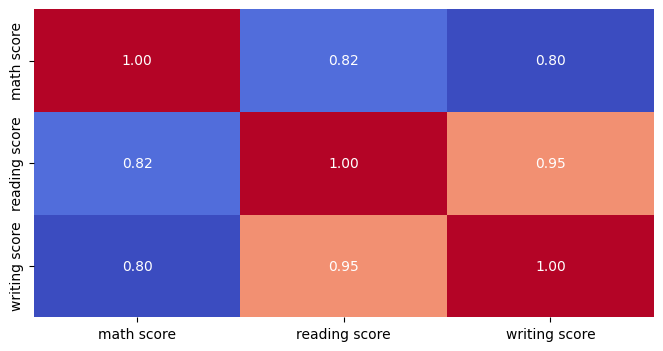

In [8]:
# --- ANÁLISIS DE CORRELACIÓN ENTRE LAS CALIFICACIONES ---

# Configura el tamaño de la figura que contendrá el gráfico.
# 'figsize=(8, 4)' establece un ancho de 8 pulgadas y una altura de 4 pulgadas.
plt.figure(figsize = (8, 4))

# Calcula la matriz de correlación de Pearson para el DataFrame 'score'.
# El método .corr() devuelve un nuevo DataFrame donde cada celda (i, j) contiene
# el coeficiente de correlación entre la columna i y la columna j.
correlation = score.corr()

# Crea un mapa de calor (heatmap) utilizando la librería Seaborn para visualizar la matriz de correlación.
# - correlation: Es el conjunto de datos (nuestra matriz de correlación).
# - annot=True: Muestra los valores numéricos (anotaciones) en cada celda del mapa.
# - fmt='.2f': Formatea las anotaciones para que se muestren como números flotantes con 2 decimales.
# - cmap='coolwarm': Establece la paleta de colores. 'coolwarm' es ideal para correlaciones,
#   ya que muestra valores positivos y negativos en colores distintos (rojo y azul).
# - cbar=False: Oculta la barra de colores lateral.
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm', cbar = False)

# Muestra el gráfico generado en la pantalla.
plt.show()

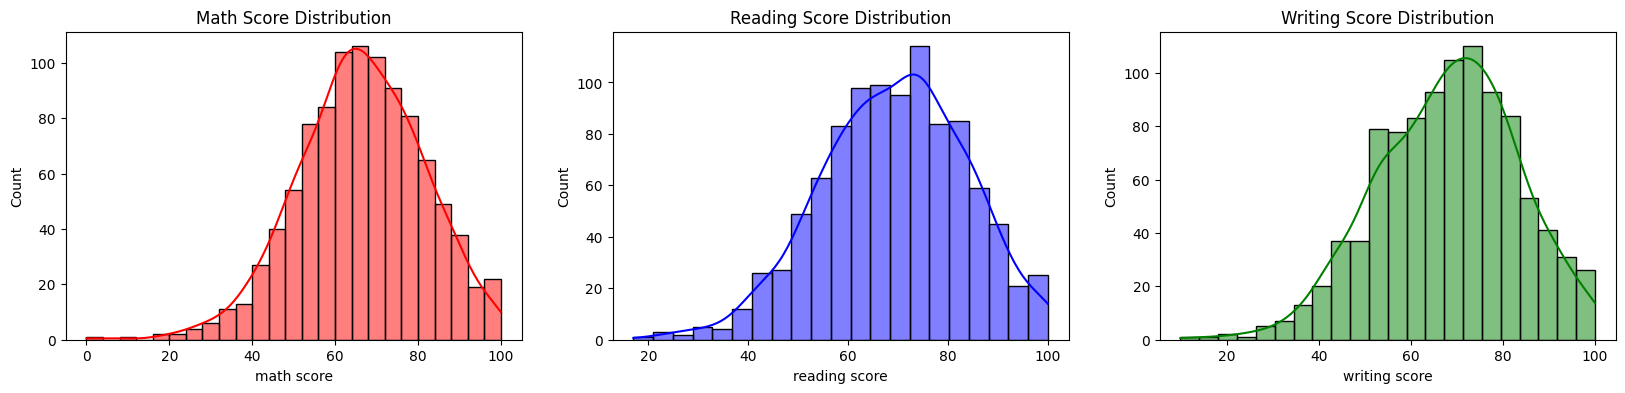

In [9]:
# --- VISUALIZACIÓN DE LA DISTRIBUCIÓN DE LAS CALIFICACIONES ---

# Crea una figura grande para contener múltiples gráficos (subplots).
# 'figsize=(20, 4)' define el ancho en 20 pulgadas y la altura en 4 pulgadas para dar espacio a los tres gráficos.
plt.figure(figsize = (20, 4))

# --- PRIMER SUBPLOT: DISTRIBUCIÓN DE 'math score' ---

# Define una cuadrícula de subplots de 1 fila por 3 columnas y selecciona el primer subplot para dibujar en él.
plt.subplot(1, 3, 1)
# Crea un histograma para la columna 'math score' usando Seaborn.
# - data['math score']: Es la serie de datos que se va a visualizar.
# - kde=True: Superpone una curva de Estimación de Densidad del Kernel (KDE) para mostrar la forma de la distribución.
# - color='red': Establece el color del histograma.
sns.histplot(data['math score'], kde = True, color = 'red')
# Añade un título específico a este primer subplot.
plt.title('Math Score Distribution')

# --- SEGUNDO SUBPLOT: DISTRIBUCIÓN DE 'reading score' ---

# Selecciona el segundo subplot de la cuadrícula (1 fila, 3 columnas, posición 2).
plt.subplot(1, 3, 2)
# Dibuja el histograma para la columna 'reading score' con una curva KDE en color azul.
sns.histplot(data['reading score'], kde = True, color = 'blue')
# Añade un título a este segundo subplot.
plt.title('Reading Score Distribution')

# --- TERCER SUBPLOT: DISTRIBUCIÓN DE 'writing score' ---

# Selecciona el tercer subplot de la cuadrícula (1 fila, 3 columnas, posición 3).
plt.subplot(1, 3, 3)
# Dibuja el histograma para la columna 'writing score' con una curva KDE en color verde.
sns.histplot(data['writing score'], kde = True, color = 'green')
# Añade un título a este tercer subplot.
plt.title('Writing Score Distribution')

# Finalmente, renderiza y muestra la figura completa con los tres subplots.
plt.show()

### **Análisis de Correlación y Distribución 📈**

Los análisis confirman dos hallazgos importantes:

1.  **Alta Correlación:** Las calificaciones en matemáticas, lectura y escritura están fuertemente correlacionadas. Esto sugiere que un buen desempeño en una materia generalmente se corresponde con un buen desempeño en las otras.

2.  **Distribución Normal:** Las tres calificaciones siguen una distribución similar (aproximadamente normal), lo que refuerza la idea de que el rendimiento de un estudiante tiende a ser consistente en las tres áreas evaluadas.

---
### **Creación de la Variable Objetivo**

Basado en la alta correlación y la distribución similar de las calificaciones, no hay una única materia que destaque como la opción obvia para predecir. Por lo tanto, para capturar el rendimiento general del estudiante, crearemos una nueva variable objetivo llamada `mean score`.

Esta variable será el **promedio de las tres calificaciones** (`math score`, `reading score` y `writing score`) y representará una medida consolidada del desempeño académico del estudiante.

In [10]:
# --- CREACIÓN DE LA VARIABLE OBJETIVO Y LIMPIEZA DEL DATAFRAME ---

# Calcula el promedio de las calificaciones para cada estudiante (fila).
# 'score.mean(axis=1)' calcula la media a lo largo de las columnas del DataFrame 'score' para cada fila.
# El resultado (un promedio por estudiante) se asigna a una nueva columna llamada 'mean score' en el DataFrame original 'data'.
data['mean score'] = score.mean(axis = 1)

# Elimina las columnas originales de calificaciones ('math score', 'reading score', 'writing score').
# Se utiliza el método .drop() para quitarlas, ya que ahora están representadas por la nueva columna 'mean score'.
# 'axis=1' es crucial, ya que especifica que estamos eliminando columnas, no filas.
data = data.drop(['math score', 'reading score', 'writing score'], axis = 1)

# Muestra las primeras 5 filas del DataFrame 'data' ya modificado.
# Esto nos permite verificar que la columna 'mean score' se ha añadido correctamente
# y que las columnas de calificaciones originales han sido eliminadas.
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,mean score
0,female,group B,bachelor's degree,standard,none,72.666667
1,female,group C,some college,standard,completed,82.333333
2,female,group B,master's degree,standard,none,92.666667
3,male,group A,associate's degree,free/reduced,none,49.333333
4,male,group C,some college,standard,none,76.333333


In [11]:
# --- VERIFICACIÓN DEL TIPO DE DATO DE LA VARIABLE OBJETIVO ---

# Imprime en pantalla el tipo de dato de la columna 'mean score'.
# 1. `data['mean score']`: Selecciona la columna (Serie de Pandas) que creamos.
# 2. `.dtype`: Es un atributo que devuelve el tipo de dato de los valores en la Serie (ej. float64, int64).
# Esto es útil para confirmar que la nueva columna es numérica, como se espera para una variable de regresión.
print("Mean score data type: ", data['mean score'].dtype)

Mean score data type:  float64


## **6. Análisis Exploratorio de Datos (EDA) 📊**

El Análisis Exploratorio de Datos (EDA) es el proceso donde "conocemos" nuestros datos a fondo. A través de visualizaciones y estadísticas, buscamos **descubrir patrones, identificar anomalías y entender las relaciones** entre las variables.

Aunque no es un requisito técnico para la codificación, realizar un buen EDA es fundamental para construir un modelo de machine learning efectivo, ya que nos revela qué características podrían ser más importantes para nuestra predicción.

---
### **6.1 Análisis de las Variables Predictoras**

Ahora, vamos a explorar la relación entre nuestras variables predictoras (las características categóricas) y nuestra variable objetivo (`mean score`). Las variables que analizaremos son:

* `gender` (Género)
* `race/ethnicity` (Grupo étnico)
* `parental level of education` (Nivel educativo de los padres)
* `lunch` (Almuerzo)
* `test preparation course` (Curso de preparación)

---
#### **6.1.1 Influencia del Género**

In [12]:
# --- ANÁLISIS DEL RENDIMIENTO PROMEDIO POR GÉNERO ---

# Crea un nuevo DataFrame llamado 'data_gender' que contiene únicamente las columnas 'gender' y 'mean score'.
# Esto nos permite aislar los datos necesarios para analizar la relación entre el género y la calificación promedio.
data_gender = data[['gender', 'mean score']]

# Muestra las primeras 10 filas del nuevo DataFrame 'data_gender'.
# Es una forma rápida de verificar que la selección de columnas fue exitosa y de visualizar una muestra de los datos.
data_gender.head(10)

,gender,mean score
0,female,72.666667
1,female,82.333333
2,female,92.666667
3,male,49.333333
4,male,76.333333
5,female,77.333333
6,female,91.666667
7,male,40.666667
8,male,65.000000
9,female,49.333333


In [13]:
# --- CONTEO DE VALORES ÚNICOS EN LA COLUMNA 'gender' ---

# Utiliza el método .value_counts() para contar el número de ocurrencias de cada categoría en la columna 'gender'.
# Esto nos permite ver rápidamente la distribución de estudiantes por género en el conjunto de datos.
# 1. data['gender']: Selecciona la columna 'gender'.
# 2. .value_counts(): Cuenta los valores únicos ('female', 'male') y devuelve el total de cada uno.
data['gender'].value_counts()

,count
gender,
female,518
male,482


### **Análisis por Género** 🚻

La variable `gender` es categórica y, como hemos visto, se divide en dos grupos: `female` y `male`.

A continuación, investigaremos si el género influye en la puntuación promedio de los estudiantes. Para ello, agruparemos los datos y compararemos el rendimiento medio de ambos grupos.

In [14]:
# --- ANÁLISIS COMPARATIVO DEL RENDIMIENTO PROMEDIO POR GÉNERO ---

# Se encadenan varios métodos de Pandas para agrupar, agregar y ordenar los datos en una sola línea.
# El resultado final sobrescribe el DataFrame 'data_gender'.

# 1. .groupby('gender', as_index=False): Agrupa el DataFrame por los valores únicos de la columna 'gender' ('female', 'male').
#    - 'as_index=False' evita que 'gender' se convierta en el índice del nuevo DataFrame, manteniéndolo como una columna regular.

# 2. .mean(): Después de agrupar, calcula el promedio (media) de las columnas numéricas para cada grupo.
#    - En este caso, calculará la 'mean score' promedio para el grupo 'female' y para el grupo 'male'.

# 3. .sort_values(...): Ordena el DataFrame resultante (que ahora tiene una fila por género).
#    - 'by='mean score'': Especifica que la ordenación se base en la columna 'mean score'.
#    - 'ascending=False': Ordena los resultados de mayor a menor.
#    - 'ignore_index=True': Reinicia el índice del DataFrame final para que sea 0, 1, 2...

data_gender = data_gender.groupby('gender', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

# Muestra el DataFrame 'data_gender' final.
# El resultado será una tabla de dos filas que muestra la calificación promedio para cada género, ordenada de mayor a menor.
data_gender

,gender,mean score
0,female,69.569498
1,male,65.837483


/tmp/ipython-input-2773701235.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'gender', y = 'mean score', data = data, palette = 'viridis')


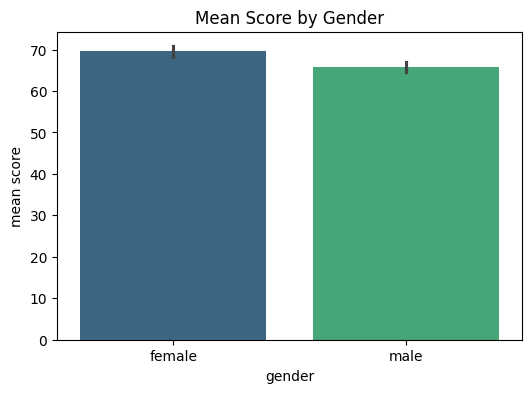

In [15]:
# --- VISUALIZACIÓN DEL RENDIMIENTO PROMEDIO POR GÉNERO ---

# Establece el tamaño de la figura (el lienzo del gráfico) en 6 pulgadas de ancho por 4 de alto.
plt.figure(figsize = (6, 4))

# Crea un gráfico de barras utilizando la librería Seaborn para comparar las calificaciones promedio.
# - x='gender': Asigna la variable categórica 'gender' al eje horizontal.
# - y='mean score': Asigna la variable numérica 'mean score' al eje vertical.
#   (Seaborn automáticamente calcula y grafica el promedio de 'mean score' para cada categoría de 'gender').
# - data=data: Especifica que los datos provienen del DataFrame 'data'.
# - palette='viridis': Aplica una paleta de colores predefinida para las barras.
sns.barplot(x = 'gender', y = 'mean score', data = data, palette = 'viridis')


# Añade un título descriptivo al gráfico.
plt.title('Mean Score by Gender')

# Muestra el gráfico final en la pantalla.
plt.show()

### **Conclusión: Rendimiento por Género** 📝

Si bien las estudiantes de **género femenino** presentan una puntuación promedio ligeramente **superior** a la de los estudiantes de **género masculino**, la diferencia no es estadísticamente significativa.

Esto sugiere que, si bien existen pequeñas variaciones, el **género no es un factor determinante** en el rendimiento académico general dentro de este conjunto de datos.

---
#### **6.1.2 Influencia del Grupo Étnico**

In [16]:
# --- ANÁLISIS COMPARATIVO DEL RENDIMIENTO PROMEDIO POR GRUPO ÉTNICO ---

# Se encadenan varios métodos de Pandas para agrupar, agregar y ordenar los datos por 'race/ethnicity'.

# 1. data[['race/ethnicity', 'mean score']]: Primero, se selecciona un subconjunto del DataFrame con solo las columnas de interés.
# 2. .groupby('race/ethnicity', as_index=False): Luego, se agrupan las filas según los valores únicos de la columna 'race/ethnicity'.
#    - 'as_index=False' asegura que 'race/ethnicity' permanezca como una columna en lugar de convertirse en el índice.
# 3. .mean(): Se calcula la media de 'mean score' para cada uno de los grupos étnicos.
# 4. .sort_values(...): Finalmente, se ordena el DataFrame resultante.
#    - 'by='mean score'': La ordenación se basa en la columna de la calificación promedio.
#    - 'ascending=True': Ordena los grupos de menor a mayor rendimiento.
#    - 'ignore_index=True': Reinicia el índice del DataFrame final (0, 1, 2, ...).

data_race = data[['race/ethnicity', 'mean score']].groupby('race/ethnicity', as_index = False).mean().sort_values(by = 'mean score', ascending = True, ignore_index = True)

# Muestra la tabla resultante, que contiene la calificación promedio para cada grupo étnico, ordenada de menor a mayor.
data_race

,race/ethnicity,mean score
0,group A,62.992509
1,group B,65.468421
2,group C,67.131661
3,group D,69.179389
4,group E,72.752381


In [17]:
# --- RENOMBRADO DE COLUMNAS PARA MEJOR MANEJO ---

# Utiliza el método .rename() para cambiar los nombres de las columnas en el DataFrame 'data_race'.
# Esto se hace para tener nombres más cortos y fáciles de manejar en el código.

# - columns={"old_name": "new_name", ...}: Se pasa un diccionario donde las claves son los nombres
#   actuales de las columnas y los valores son los nuevos nombres deseados.
#   - "race/ethnicity" se convierte en "ethnicity".
#   - "mean score" se convierte en "m_score".
# - inplace=True: Este argumento es muy importante. Modifica el DataFrame 'data_race' directamente
#   sin necesidad de reasignarlo (ej. data_race = data_race.rename(...)).
data_race.rename(columns={"race/ethnicity": "ethnicity", "mean score":"m_score"}, inplace=True)

# Muestra el DataFrame 'data_race' después de haber renombrado las columnas.
# Esto nos permite verificar que los cambios se aplicaron correctamente.
data_race

,ethnicity,m_score
0,group A,62.992509
1,group B,65.468421
2,group C,67.131661
3,group D,69.179389
4,group E,72.752381


/tmp/ipython-input-4024646711.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = data_race, x = 'ethnicity', y = 'm_score', order=data_race.sort_values('m_score').ethnicity, palette = 'viridis')


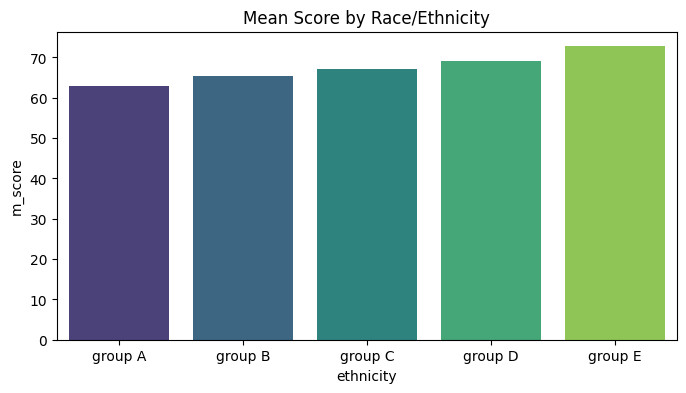

In [18]:
# --- VISUALIZACIÓN DEL RENDIMIENTO PROMEDIO POR GRUPO ÉTNICO ---

# Establece el tamaño de la figura (el lienzo del gráfico) en 8 pulgadas de ancho por 4 de alto.
plt.figure(figsize = (8, 4))

# Crea un gráfico de barras utilizando Seaborn para comparar las calificaciones promedio por grupo étnico.
# - data=data_race: Especifica que los datos provienen del DataFrame 'data_race' que ya está agrupado y promediado.
# - x='ethnicity': Asigna la columna 'ethnicity' al eje horizontal.
# - y='m_score': Asigna la columna 'm_score' (calificación promedio) al eje vertical (altura de las barras).
# - order=data_race.sort_values('m_score').ethnicity: Un paso clave para la claridad. Ordena las barras en el gráfico
#   de menor a mayor según la calificación promedio, lo que facilita la comparación visual.
# - palette='viridis': Aplica una paleta de colores predefinida a las barras del gráfico.
sns.barplot(data = data_race, x = 'ethnicity', y = 'm_score', order=data_race.sort_values('m_score').ethnicity, palette = 'viridis')

# Añade un título descriptivo al gráfico.
plt.title('Mean Score by Race/Ethnicity')

# Muestra el gráfico final en la pantalla.
plt.show()

### **Conclusión: Rendimiento por Grupo Étnico** 📝

El análisis revela una clara tendencia ascendente en las calificaciones promedio a medida que se avanza del `group A` al `group E`. Específicamente, los estudiantes del **Grupo E** obtienen, en promedio, el rendimiento más alto, mientras que los del **Grupo A** presentan el más bajo.

Es crucial interpretar este hallazgo con cautela. Si bien observamos una **correlación**, no podemos establecer una relación de **causalidad**. Sin un contexto más profundo, sería inapropiado concluir que el grupo étnico es la causa directa de estas diferencias en el rendimiento.

---
#### **6.1.3 Influencia del Nivel Educativo de los Padres**

In [19]:
# --- ANÁLISIS COMPARATIVO DEL RENDIMIENTO PROMEDIO POR NIVEL EDUCATIVO DE LOS PADRES ---

# Se encadenan varios métodos de Pandas para seleccionar, agrupar, promediar y ordenar los datos.

# 1. data[['parental level of education', 'mean score']]: Selecciona un subconjunto del DataFrame con las dos columnas de interés.
# 2. .groupby('parental level of education', as_index=False): Agrupa las filas según los valores únicos de la columna de educación.
#    - 'as_index=False' evita que el nivel educativo se convierta en el índice, manteniéndolo como una columna.
# 3. .mean(): Calcula la media de 'mean score' para cada nivel educativo.
# 4. .sort_values(...): Ordena el DataFrame resultante.
#    - 'by='mean score'': Especifica que la ordenación se base en la calificación promedio.
#    - 'ascending=True': Ordena los grupos de menor a mayor rendimiento.
#    - 'ignore_index=True': Reinicia el índice del DataFrame final para que sea 0, 1, 2...
data_edu = data[['parental level of education', 'mean score']].groupby('parental level of education', as_index = False).mean().sort_values(by = 'mean score', ascending = True, ignore_index = True)

In [20]:
# --- RENOMBRADO DE COLUMNAS PARA MEJOR MANEJO Y LEGIBILIDAD ---

# Utiliza el método .rename() para cambiar los nombres de las columnas en el DataFrame 'data_edu'.
# Esto se hace para tener nombres más cortos y sin espacios, lo que facilita su uso en el código.

# - columns={...}: Se pasa un diccionario donde las claves son los nombres actuales de las columnas
#   y los valores son los nuevos nombres deseados.
#   - "parental level of education" se convierte en "level_edu".
#   - "mean score" se convierte en "m_score".
# - inplace=True: Este argumento modifica el DataFrame 'data_edu' directamente,
#   sin necesidad de reasignarlo a una nueva variable.
data_edu.rename(columns={"parental level of education": "level_edu", "mean score":"m_score"}, inplace=True)

# Muestra el DataFrame 'data_edu' después de haber renombrado las columnas.
# Esto nos permite verificar que los cambios se aplicaron correctamente. 🏷️
data_edu

,level_edu,m_score
0,high school,63.096939
1,some high school,65.108007
2,some college,68.476401
3,associate's degree,69.569069
4,bachelor's degree,71.923729
5,master's degree,73.598870


/tmp/ipython-input-3286712040.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = data_edu, x = 'level_edu', y = 'm_score', order=data_edu.sort_values('m_score').level_edu, palette = 'viridis')


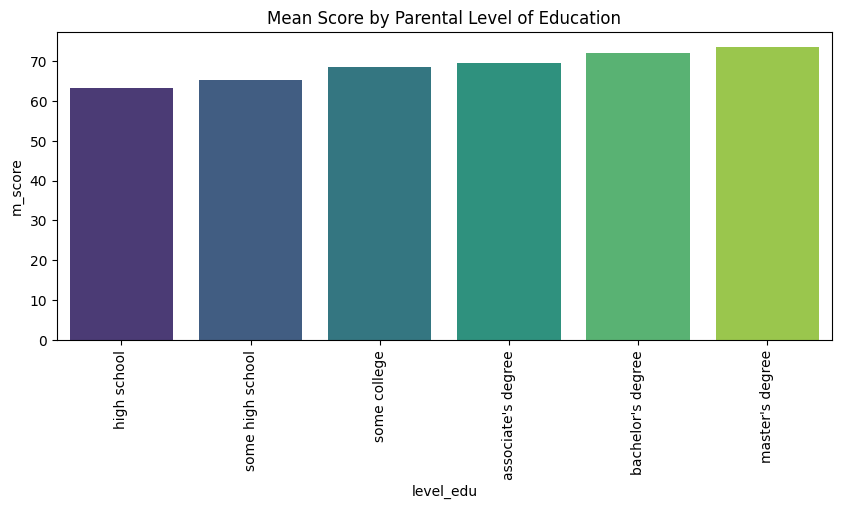

In [21]:
# --- VISUALIZACIÓN DEL RENDIMIENTO PROMEDIO POR NIVEL EDUCATIVO DE LOS PADRES ---

# Establece el tamaño de la figura (el lienzo del gráfico) en 10 pulgadas de ancho por 4 de alto.
plt.figure(figsize = (10, 4))

# Crea un gráfico de barras utilizando Seaborn para comparar las calificaciones promedio por nivel educativo.
# - data=data_edu: Especifica que los datos provienen del DataFrame 'data_edu' que ya está agrupado y promediado.
# - x='level_edu': Asigna la columna 'level_edu' al eje horizontal.
# - y='m_score': Asigna la columna 'm_score' (calificación promedio) al eje vertical (altura de las barras).
# - order=data_edu.sort_values('m_score').level_edu: Ordena las barras en el gráfico de menor a mayor
#   según la calificación promedio, lo que facilita la comparación visual.
# - palette='viridis': Aplica una paleta de colores predefinida a las barras del gráfico.
sns.barplot(data = data_edu, x = 'level_edu', y = 'm_score', order=data_edu.sort_values('m_score').level_edu, palette = 'viridis')

# Añade un título descriptivo al gráfico.
plt.title('Mean Score by Parental Level of Education')

# Rota las etiquetas del eje X en 90 grados para evitar que se superpongan y mejorar la legibilidad.
# El punto y coma al final es opcional y se usa para suprimir la salida de texto del objeto matplotlib.
plt.xticks(rotation = 90);

# Muestra el gráfico final en la pantalla.
plt.show()

### **Conclusión: Nivel Educativo de los Padres** 📝

[cite_start]Los resultados confirman una tendencia clara y esperada: existe una **correlación positiva** entre el nivel educativo de los padres y el rendimiento académico de los estudiantes[cite: 21, 23]. [cite_start]A medida que aumenta la formación de los padres, también lo hace la calificación promedio de sus hijos[cite: 21, 23].

***
#### **6.1.4 Influencia del Almuerzo**


In [22]:
# --- ANÁLISIS COMPARATIVO DEL RENDIMIENTO PROMEDIO POR TIPO DE ALMUERZO ---

# Se encadenan varios métodos de Pandas para analizar el impacto del tipo de almuerzo en las calificaciones.

# 1. data[['lunch', 'mean score']]: Selecciona un subconjunto del DataFrame con solo las columnas 'lunch' y 'mean score'.
# 2. .groupby('lunch', as_index=False): Agrupa las filas según los valores únicos de la columna 'lunch' ('standard' y 'free/reduced').
#    - 'as_index=False' mantiene 'lunch' como una columna regular en lugar de convertirla en el índice del DataFrame.
# 3. .mean(): Calcula la calificación promedio ('mean score') para cada uno de los grupos de almuerzo.
# 4. .sort_values(...): Ordena el DataFrame resultante.
#    - by='mean score': La ordenación se basa en la columna de la calificación promedio.
#    - ascending=False: Ordena los grupos de mayor a menor rendimiento.
#    - ignore_index=True: Reinicia el índice del DataFrame final (0, 1, ...).
data[['lunch', 'mean score']].groupby('lunch', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,lunch,mean score
0,standard,70.837209
1,free/reduced,62.199061


/tmp/ipython-input-587951932.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'lunch', y = 'mean score', data = data, palette = 'viridis')


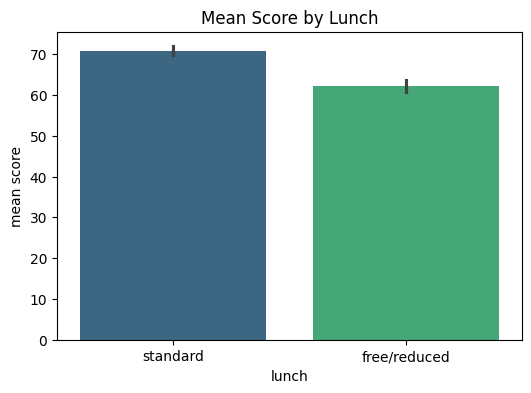

In [23]:
# --- VISUALIZACIÓN DEL RENDIMIENTO PROMEDIO POR TIPO DE ALMUERZO ---

# Establece el tamaño de la figura (el lienzo del gráfico) en 6 pulgadas de ancho por 4 de alto.
plt.figure(figsize = (6, 4))

# Crea un gráfico de barras utilizando Seaborn para comparar las calificaciones promedio.
# - x='lunch': Asigna la variable categórica 'lunch' al eje horizontal.
# - y='mean score': Asigna la variable numérica 'mean score' al eje vertical.
#   (Seaborn automáticamente calcula y grafica el promedio de 'mean score' para cada categoría de 'lunch').
# - data=data: Especifica que los datos provienen del DataFrame 'data'.
# - palette='viridis': Aplica una paleta de colores predefinida para las barras.
sns.barplot(x = 'lunch', y = 'mean score', data = data, palette = 'viridis')

# Añade un título descriptivo al gráfico.
plt.title('Mean Score by Lunch')

# Muestra el gráfico final en la pantalla.
plt.show()

### **Conclusión: Impacto del Tipo de Almuerzo** 📝

El análisis muestra una diferencia notable en el rendimiento: los estudiantes con **almuerzo estándar** obtienen, en promedio, **calificaciones más altas** que aquellos con almuerzo gratuito o reducido.

Esta variable puede ser interpretada como un indicador indirecto del estatus socioeconómico del estudiante. Bajo esta premisa, los resultados sugieren que los estudiantes de entornos económicos más favorables tienden a presentar un mejor rendimiento académico, lo cual es una tendencia comúnmente observada en estudios educativos.

***
#### **6.1.5 Influencia del Curso de Preparación para Exámenes**

In [24]:
# --- ANÁLISIS COMPARATIVO DEL RENDIMIENTO PROMEDIO SEGÚN LA PREPARACIÓN DEL EXAMEN ---

# Se encadenan varios métodos de Pandas para analizar el impacto del curso de preparación en las calificaciones.

# 1. data[['test preparation course', 'mean score']]: Selecciona un subconjunto del DataFrame con las dos columnas de interés.
# 2. .groupby('test preparation course', as_index=False): Agrupa las filas según los valores únicos de la columna 'test preparation course' ('completed' y 'none').
#    - 'as_index=False' mantiene 'test preparation course' como una columna regular en lugar de convertirla en el índice.
# 3. .mean(): Calcula la calificación promedio ('mean score') para cada uno de los grupos de preparación.
# 4. .sort_values(...): Ordena el DataFrame resultante.
#    - by='mean score': La ordenación se basa en la columna de la calificación promedio.
#    - ascending=False: Ordena los grupos de mayor a menor rendimiento.
#    - ignore_index=True: Reinicia el índice del DataFrame final (0, 1, ...).
data[['test preparation course', 'mean score']].groupby('test preparation course', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,test preparation course,mean score
0,completed,72.669460
1,none,65.038941


/tmp/ipython-input-2892718168.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'test preparation course', y = 'mean score', data = data, palette = 'viridis')


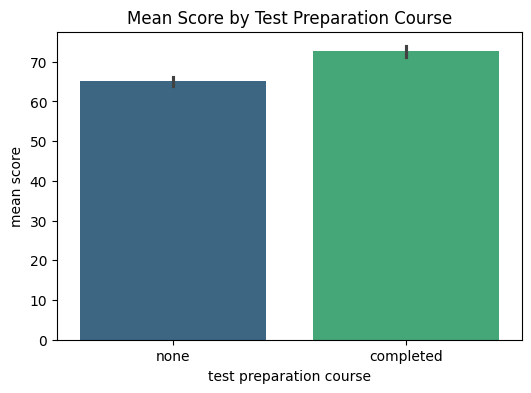

In [25]:
# --- VISUALIZACIÓN DEL RENDIMIENTO PROMEDIO SEGÚN LA PREPARACIÓN DEL EXAMEN ---

# Establece el tamaño de la figura (el lienzo del gráfico) en 6 pulgadas de ancho por 4 de alto.
plt.figure(figsize = (6, 4))

# Crea un gráfico de barras utilizando Seaborn para comparar las calificaciones promedio.
# - x='test preparation course': Asigna la variable categórica 'test preparation course' al eje horizontal.
# - y='mean score': Asigna la variable numérica 'mean score' al eje vertical.
#   (Seaborn automáticamente calcula y grafica el promedio de 'mean score' para cada categoría).
# - data=data: Especifica que los datos provienen del DataFrame 'data'.
# - palette='viridis': Aplica una paleta de colores predefinida para las barras.
sns.barplot(x = 'test preparation course', y = 'mean score', data = data, palette = 'viridis')

# Añade un título descriptivo al gráfico.
plt.title('Mean Score by Test Preparation Course')

# Muestra el gráfico final en la pantalla.
plt.show()

### **Conclusión: Impacto del Curso de Preparación** 📝

Como era de esperar, los resultados son concluyentes. Los estudiantes que **completaron el curso de preparación** obtuvieron, en promedio, **calificaciones significativamente más altas**.

Este hallazgo confirma la lógica de que una mayor preparación y estudio se traducen directamente en un mejor rendimiento en los exámenes.

***
### **6.2 Análisis de la Variable Objetivo (`mean score`)**


In [26]:
# --- ANÁLISIS ESTADÍSTICO DESCRIPTIVO DE LA VARIABLE OBJETIVO ---

# Utiliza el método .describe() en la columna 'mean score' para generar estadísticas descriptivas.
# Este es un paso fundamental para entender la distribución de nuestra variable objetivo.
# El resultado incluye:
#   - count: El número total de estudiantes (entradas no nulas).
#   - mean: La calificación promedio de todos los estudiantes.
#   - std: La desviación estándar, que mide la dispersión de las calificaciones respecto al promedio.
#   - min: La calificación promedio más baja registrada.
#   - 25%: El primer cuartil (percentil 25). El 25% de los estudiantes tuvo una calificación por debajo de este valor.
#   - 50%: La mediana (percentil 50). La calificación que se encuentra justo en el medio del conjunto de datos.
#   - 75%: El tercer cuartil (percentil 75). El 75% de los estudiantes tuvo una calificación por debajo de este valor.
#   - max: La calificación promedio más alta registrada.
data['mean score'].describe()

,mean score
count,1000.000000
mean,67.770667
std,14.257326
min,9.000000
25%,58.333333
50%,68.333333
75%,77.666667
max,100.000000


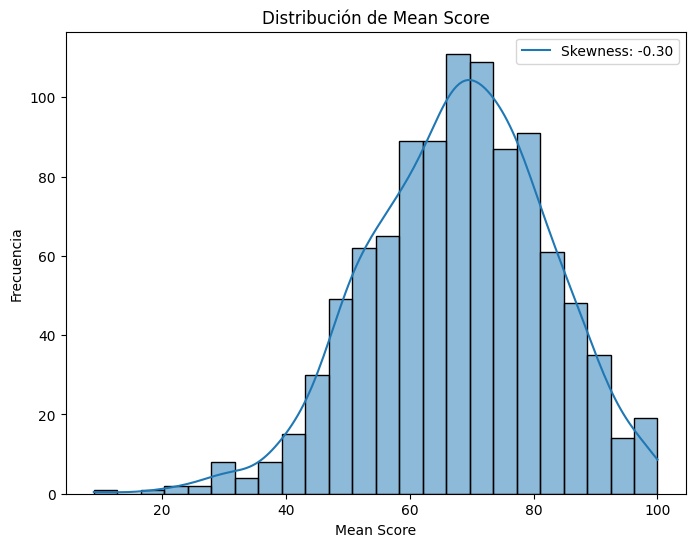

In [27]:
# --- VISUALIZACIÓN DE LA DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ---

# Establece el tamaño de la figura (el lienzo del gráfico) en 8 pulgadas de ancho por 6 de alto.
plt.figure(figsize=(8, 6))

# Crea un histograma de la columna 'mean score' utilizando Seaborn.
# - data['mean score']: Es la serie de datos que se va a visualizar.
# - kde=True: Superpone una curva de Estimación de Densidad del Kernel (KDE) para mostrar la forma suave de la distribución.
sns.histplot(data['mean score'], kde=True)

# --- CÁLCULO Y VISUALIZACIÓN DE LA ASIMETRÍA (SKEWNESS) ---

# Calcula la asimetría (skewness) de la distribución de 'mean score'.
# La asimetría mide la falta de simetría de una distribución de datos. Un valor cercano a 0 indica simetría.
skewness = data['mean score'].skew()

# Añade una leyenda al gráfico para mostrar el valor de la asimetría calculado.
# - f'Skewness: {skewness:.2f}': Crea una cadena de texto formateada que muestra el valor con solo dos decimales.
plt.legend([f'Skewness: {skewness:.2f}'])


# --- ETIQUETAS Y TÍTULO DEL GRÁFICO ---

# Añade un título descriptivo al gráfico.
plt.title('Distribución de Mean Score')

# Etiqueta el eje horizontal (eje X).
plt.xlabel('Mean Score')

# Etiqueta el eje vertical (eje Y).
plt.ylabel('Frecuencia')

# Muestra el gráfico final en la pantalla.
plt.show()

### **¿Qué es la Asimetría (Skewness)?** 📐

La **asimetría** (o skewness) es una medida estadística que nos dice si la distribución de nuestros datos es simétrica o si, por el contrario, se inclina más hacia un lado. Piénsalo como la "cola" de la distribución:

* **Asimetría Positiva (Sesgo a la derecha) `>` 0:** La cola de la distribución es más larga en el lado derecho. Esto significa que la mayoría de los datos se concentran a la izquierda del promedio, pero hay algunos valores atípicamente altos que "estiran" la distribución.

* **Asimetría Negativa (Sesgo a la izquierda) `<` 0:** La cola es más larga en el lado izquierdo. La mayoría de los datos se agrupan a la derecha del promedio, pero algunos valores atípicamente bajos "estiran" la distribución hacia la izquierda.

* **Simetría (Skewness ≈ 0):** La distribución es perfectamente balanceada a ambos lados de la media, como en una campana de Gauss ideal.

## **7. Codificación de Características (Feature Encoding) 🤖**

Tras explorar y entender las variables, el siguiente paso crucial es preparar los datos para el modelo de machine learning. El objetivo principal es convertir nuestras **variables categóricas** (texto) en un formato **numérico** que los algoritmos puedan procesar. Este proceso se conoce como **codificación de características**.

[cite_start]Para elegir la técnica de codificación correcta, primero debemos distinguir entre dos tipos de variables categóricas: **nominales** y **ordinales**. [cite: 614, 2188]

***
### **Variables Nominales vs. Ordinales**

* **Variable Nominal:** Es una categoría que **no tiene un orden o jerarquía intrínseca**. [cite_start]Los valores son simplemente etiquetas distintas. [cite: 625, 2188]
    * **Ejemplos:** `gender` (male, female) o `race/ethnicity` (group A, group B).

* [cite_start]**Variable Ordinal:** Es una categoría que **sí sigue un orden lógico o jerárquico**. [cite: 625] La distancia entre los valores no es necesariamente uniforme, pero su secuencia es importante.
    * **Ejemplos:** Nivel educativo (`high school`, `bachelor's degree`, `master's degree`) o tallas de ropa (pequeño, mediano, grande).

La elección del codificador depende directamente de este tipo de variable:
* Usaremos **`OneHotEncoder`** para las variables **nominales**.
* Usaremos **`OrdinalEncoder`** para las variables **ordinales**.

### **7.1 Codificación de Variables Nominales**

Las variables nominales en nuestro dataset son aquellas que representan categorías sin un orden jerárquico. Estas incluyen:

* `gender`
* `race/ethnicity`
* `lunch`
* `test preparation course`

Para transformar estas variables en un formato numérico, exploraremos dos técnicas populares: `OneHotEncoder` de Scikit-learn y `get_dummies` de Pandas. Ambas crean nuevas columnas binarias (con valores de 0 o 1) para cada categoría, pero se aplican en diferentes etapas del flujo de trabajo de machine learning.

---
#### **7.1.1 Usando `OneHotEncoder` de Scikit-learn**

### **One-Hot Encoding: Creando "Interruptores" para Categorías** 💡

El **`OneHotEncoder`** es una de las técnicas más comunes para manejar variables **nominales**. Su lógica es simple pero poderosa: transforma cada categoría en su propia columna binaria (con valores de 0 o 1).

Piensa en ello como crear un conjunto de interruptores de "encendido/apagado" para cada categoría. Si una fila pertenece a una categoría, el interruptor para esa columna se enciende (`1`), mientras que todos los demás se apagan (`0`).

**Ejemplo:**
Si tenemos una columna `gender` con las categorías `male` y `female`, el `OneHotEncoder` la convertiría en dos nuevas columnas:

| gender_male | gender_female |
| :--- | :--- |
| 1 | 0 |
| 0 | 1 |
| 0 | 1 |

---
#### **Evitando la Multicolinealidad (La Trampa de las Variables Dummy)**

Un detalle crucial al usar one-hot encoding es evitar la **multicolinealidad**. Esto ocurre cuando una variable predictora en un modelo puede ser predicha linealmente a partir de las otras. En nuestro ejemplo, si `gender_male` es `0`, sabemos con un 100% de certeza que `gender_female` debe ser `1`. Esta información es redundante y puede confundir a algunos modelos de regresión.

**La solución es simple:** si tenemos *n* categorías, solo necesitamos crear *n-1* columnas. La categoría restante se infiere cuando todas las demás columnas son `0`. Por lo tanto, siempre eliminaremos una de las columnas binarias generadas.

In [28]:
# --- INSTANCIACIÓN Y CONFIGURACIÓN DEL OneHotEncoder ---

# Crea una instancia de la clase OneHotEncoder, que se usará para codificar las variables nominales.
# La instancia se guarda en la variable 'ohe' y se configura con dos argumentos importantes:

# 1. sparse_output=False:
#    Por defecto, OneHotEncoder devuelve una matriz dispersa (sparse matrix) para ahorrar memoria.
#    Al establecer este parámetro en 'False', le indicamos que devuelva un array de NumPy denso,
#    que es más fácil de visualizar e interpretar directamente.

# 2. drop='first':
#    Este es un paso crucial para evitar la multicolinealidad (la "trampa de las variables dummy").
#    Le indica al codificador que, para cada característica con 'n' categorías, debe crear solo 'n-1' columnas,
#    eliminando la primera categoría. La información de la categoría eliminada queda implícita en las demás.

ohe = OneHotEncoder(sparse_output=False, drop='first')

In [29]:
# --- APLICACIÓN DEL OneHotEncoder Y VISTA PREVIA DEL RESULTADO ---

# Aplica el codificador 'ohe' a la columna 'gender' del DataFrame.
# El método .fit_transform() realiza dos acciones en un solo paso:
#   1. .fit(): Aprende las categorías únicas presentes en la columna 'gender' (ej. 'female', 'male').
#   2. .transform(): Aplica la codificación, convirtiendo la columna original en una nueva columna numérica binaria.
#   - data[['gender']]: Se usan dobles corchetes para pasar la columna como un DataFrame, que es el formato que espera scikit-learn.

# Finalmente, [:5] selecciona y muestra solo las primeras 5 filas del resultado transformado.
# Esto nos permite previsualizar cómo se ha codificado la columna sin imprimir todo el array.
ohe.fit_transform(data[['gender']])[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [30]:
# --- COMPARACIÓN CON LOS DATOS ORIGINALES ---

# Selecciona la columna 'gender' del DataFrame original 'data'.
# A continuación, utiliza el método .head() para mostrar las primeras 5 filas de esta columna.
# El propósito de esta celda es mostrar los valores originales ('female', 'male', etc.)
# para que se puedan comparar visualmente con la salida codificada de la celda anterior.
data['gender'].head()

,gender
0,female
1,female
2,female
3,male
4,male


In [31]:
# --- INSPECCIÓN DE LAS CATEGORÍAS APRENDIDAS POR EL ENCODER ---

# Accede al atributo '.categories_' del objeto 'ohe' (nuestro OneHotEncoder ya ajustado).
# Este atributo almacena una lista con las categorías únicas que el codificador encontró en cada columna durante el paso de '.fit()'.
# Es muy útil para verificar qué categorías ha aprendido el modelo y en qué orden las está procesando.
ohe.categories_

[array(['female', 'male'], dtype=object)]

### **Interpretación del Resultado**

El `OneHotEncoder` ha transformado exitosamente la columna `gender` en un formato numérico. Lo ha hecho creando una **columna binaria** para cada categoría (`female` y `male`), donde:

* Un **1** indica la **presencia** de la categoría en esa fila.
* Un **0** indica la **ausencia**.

De esta manera, una variable categórica se convierte en datos numéricos que un modelo de machine learning puede procesar.

***
#### **7.1.2 Usando `get_dummies` de Pandas**

In [32]:
# --- APLICACIÓN DE LA CODIFICACIÓN ONE-HOT USANDO PANDAS ---

# Utiliza la función pd.get_dummies() de Pandas para realizar la codificación one-hot en la columna 'gender'.
# Esta función crea un nuevo DataFrame donde:
#   - Los nombres de las columnas son las categorías únicas de la columna original ('female', 'male').
#   - Los valores son 1 (si la fila pertenece a esa categoría) o 0 (si no).

# A continuación, se usa .head() para mostrar las primeras 5 filas del DataFrame resultante,
# permitiendo una rápida verificación del proceso de codificación.
pd.get_dummies(data['gender']).head()

,female,male
0,True,False
1,True,False
2,True,False
3,False,True
4,False,True


Aunque ambos enfoques producen el mismo resultado, **`OneHotEncoder` es generalmente la opción preferida** para construir modelos de machine learning. ¿Por qué?

* **Integración con Pipelines**: `OneHotEncoder` se integra perfectamente en los `Pipelines` de Scikit-learn. Esto permite encadenar el preprocesamiento y el modelado en un flujo de trabajo automatizado y reproducible.
* **Consistencia entre Entrenamiento y Prueba**: Al ser parte de un pipeline, el `OneHotEncoder` se "ajusta" (*fit*) solo con los datos de entrenamiento y luego "transforma" (*transform*) tanto el conjunto de entrenamiento como el de prueba de la misma manera. Esto evita errores comunes, como inconsistencias en las columnas si una categoría aparece en un conjunto pero no en el otro.
* **Compatibilidad con Herramientas Avanzadas**: Su uso en pipelines lo hace compatible con herramientas de Scikit-learn como `GridSearchCV` y `cross_val_score`, lo que resulta en una optimización y validación de modelos más robusta y fiable.

En resumen, mientras `get_dummies` es excelente para un análisis exploratorio rápido, **`OneHotEncoder` es la herramienta estándar para el preprocesamiento en un flujo de machine learning serio**.

***
## **7.2 Codificación de Variables Ordinales**

Ahora, nos enfocaremos en la única variable ordinal de nuestro dataset: **`parental level of education`**. Esta característica tiene una jerarquía clara (ej. "maestría" es más que "secundaria").

Para codificarla, también exploraremos dos métodos: `OrdinalEncoder` de Scikit-learn y el método `.map()` de Pandas.

***
### **7.2.1 `OrdinalEncoder` de Scikit-learn**

A diferencia de `OneHotEncoder`, que crea nuevas columnas, **`OrdinalEncoder`** transforma las categorías en una única columna de **números enteros que respetan el orden jerárquico**.

Por ejemplo, podría asignar:
* `'some high school'` -> `0`
* `'high school'` -> `1`
* `'some college'` -> `2`
* `"bachelor's degree"` -> `3`

Esto permite que el modelo de machine learning no solo vea los datos como números, sino que también entienda la relación de orden entre ellos, lo que puede llevar a predicciones más precisas.

Veamos cómo aplicarlo a nuestra columna de nivel educativo.

In [33]:
# --- IDENTIFICACIÓN DE CATEGORÍAS ÚNICAS EN LA COLUMNA DE EDUCACIÓN ---

# Se utiliza una combinación de métodos para extraer y mostrar todas las categorías únicas de la columna.
# 1. data['parental level of education']: Selecciona la columna de interés del DataFrame.
# 2. .unique(): Es un método de Pandas que devuelve un array con los valores únicos de esa columna,
#    en el orden en que aparecen por primera vez.
# 3. list(...): Convierte el array resultante en una lista de Python para una visualización más limpia.

# El objetivo de esta celda es ver todas las posibles categorías de nivel educativo que necesitaremos ordenar.
list(data['parental level of education'].unique())

["bachelor's degree",
 'some college',
 "master's degree",
 "associate's degree",
 'high school',
 'some high school']

### **Estableciendo la Jerarquía Ordinal** 📊

Para que el `OrdinalEncoder` funcione correctamente, es crucial que le especifiquemos el **orden lógico** de las categorías. Esto garantiza que la codificación numérica (ej: 0, 1, 2...) refleje la jerarquía real de los datos, desde el nivel más bajo al más alto.

Para nuestra variable `parental level of education`, definiremos el siguiente orden ascendente:

1.  `some high school`
2.  `high school`
3.  `some college`
4.  `associate's degree`
5.  `bachelor's degree`
6.  `master's degree`

In [34]:
# --- DEFINICIÓN DEL ORDEN JERÁRQUICO PARA LA VARIABLE ORDINAL ---

# Crea una lista de Python que contiene las categorías de nivel educativo.
# Es fundamental definir esta lista en el orden lógico y jerárquico correcto (de menor a mayor nivel).
# Esta lista se utilizará más adelante para configurar el OrdinalEncoder y asegurar que la codificación numérica
# refleje correctamente la jerarquía de los niveles educativos.
education_categories = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]

In [35]:
# --- INSTANCIACIÓN DEL ORDINALENCODER CON UN ORDEN ESPECÍFICO ---

# Crea una instancia de la clase OrdinalEncoder, que se usará para codificar la variable ordinal.
# - categories=[education_categories]: Este es el argumento más importante. Le pasamos la lista
#   'education_categories' que definimos en la celda anterior.
#   Al hacer esto, forzamos al codificador a usar nuestro orden jerárquico específico
#   en lugar de inferir uno automáticamente (lo que podría ser incorrecto).
#   La estructura de lista anidada ([education_categories]) se debe a que el encoder puede
#   manejar múltiples columnas, cada una con su propia lista de categorías.
oe = OrdinalEncoder(categories = [education_categories])

In [36]:
# --- APLICACIÓN DEL ORDINALENCODER A LA COLUMNA DE EDUCACIÓN ---

# Aplica el codificador ordinal 'oe' a la columna 'parental level of education'.
# El método .fit_transform() realiza dos acciones en un solo paso:
#   1. .fit(): Verifica que las categorías en la columna coincidan con las que especificamos en 'education_categories'.
#   2. .transform(): Aplica la codificación, convirtiendo cada categoría de texto en su número entero correspondiente
#      según el orden que definimos (ej. 'some high school' -> 0.0, 'high school' -> 1.0, etc.).
#   - Se usan dobles corchetes [['...']] para pasar la columna como un DataFrame, que es el formato que espera scikit-learn.

# Finalmente, [:5] selecciona y muestra solo las primeras 5 filas del resultado transformado.
# Esto nos permite previsualizar cómo se ha codificado la columna numéricamente.
oe.fit_transform(data[['parental level of education']])[:5]

array([[4.],
       [2.],
       [5.],
       [3.],
       [2.]])

In [37]:
# --- COMPARACIÓN CON LOS DATOS ORIGINALES DE LA COLUMNA ORDINAL ---

# Selecciona la columna 'parental level of education' del DataFrame original 'data'.
# A continuación, utiliza el método .head() para mostrar las primeras 5 filas de esta columna.
# El propósito de esta celda es mostrar los valores de texto originales para que se puedan
# comparar visualmente con la salida numérica del OrdinalEncoder de la celda anterior.
data['parental level of education'].head()

,parental level of education
0,bachelor's degree
1,some college
2,master's degree
3,associate's degree
4,some college


### **Interpretación del Resultado**

El `OrdinalEncoder` ha transformado con éxito las categorías de texto en valores numéricos que respetan la jerarquía que definimos. La asignación resultante es la siguiente:

> * `some high school` → **0**
> * `high school` → **1**
> * `some college` → **2**
> * `associate's degree` → **3**
> * `bachelor's degree` → **4**
> * `master's degree` → **5**

---
### **7.2.2 Alternativa: El Método `.map()` de Pandas**

Existe un enfoque más manual para esta tarea utilizando el método `.map()` de Pandas. Este método es muy directo y útil para codificaciones sencillas, aunque puede volverse tedioso si la variable tiene una gran cantidad de categorías, ya que requiere la creación explícita de un diccionario de mapeo.

In [38]:
# --- CODIFICACIÓN ORDINAL MANUAL USANDO EL MÉTODO .map() DE PANDAS ---

# Aplica el método .map() a la columna 'parental level of education' para realizar una codificación manual.

# 1. data['parental level of education']: Selecciona la columna (Serie) que queremos transformar.
# 2. .map({...}): Este método toma un diccionario de Python como argumento.
#    - El diccionario define explícitamente la correspondencia (mapeo) entre cada categoría de texto (la clave)
#      y su valor numérico deseado (el valor).
#    - Pandas recorrerá la columna y reemplazará cada texto con su número correspondiente según este diccionario.
#    - Este enfoque es directo pero menos flexible que OrdinalEncoder, especialmente dentro de un pipeline.

# 3. .head(): Muestra las primeras 5 filas del resultado de la transformación para una rápida verificación.
data['parental level of education'].map({'some high school': 0,
                                         'high school': 1,
                                         'some college': 2,
                                         "associate's degree": 3,
                                         "bachelor's degree": 4,
                                         "master's degree": 5}).head()

,parental level of education
0,4
1,2
2,5
3,3
4,2


### **7.3 Unificando el Preprocesamiento con `ColumnTransformer`** ⚙️

Ahora que entendemos cómo codificar variables nominales y ordinales por separado, el siguiente paso es **aplicar estas transformaciones de manera simultánea y organizada**. Para el resto de este notebook, usaremos `OneHotEncoder` y `OrdinalEncoder` como nuestras herramientas de codificación.

Vamos a combinarlas en un único paso de preprocesamiento utilizando `make_column_transformer` de Scikit-learn, una herramienta esencial para crear flujos de trabajo limpios y eficientes.

-----

#### **¿Qué es `make_column_transformer`?**

Piensa en `make_column_transformer` como un "director de orquesta" para el preprocesamiento de tus datos. Su función es aplicar **diferentes transformaciones a diferentes columnas** de tu dataset, todo dentro de un solo objeto.

Es especialmente útil porque la mayoría de los datasets, como el nuestro, contienen una mezcla de tipos de datos (categóricos, numéricos, etc.) que requieren tratamientos distintos.

-----

#### **Ventajas de Usar `make_column_transformer`**

1.  **Código Limpio y Organizado**: Centraliza todo el preprocesamiento de columnas en un solo lugar, haciendo el código más fácil de leer y mantener.
2.  **Integración con Pipelines**: El objeto resultante se integra perfectamente en un `Pipeline` de Scikit-learn, lo que automatiza todo el flujo de trabajo desde la limpieza de datos hasta el entrenamiento del modelo.
3.  **Flexibilidad**: Puedes aplicar cualquier tipo de transformador de Scikit-learn, como `OneHotEncoder` para variables nominales, `OrdinalEncoder` para ordinales, o escaladores numéricos como `StandardScaler`.
4.  **Manejo de Columnas Restantes**: Te permite decidir qué hacer con las columnas que no especificaste. Puedes dejarlas como están (`'passthrough'`) o eliminarlas (`'drop'`).

-----

#### **Ejemplo Práctico Adaptado a Nuestro Dataset**

A continuación, se muestra cómo definiríamos un transformador para nuestro conjunto de datos de estudiantes:

```python
# Importaciones necesarias
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# 1. Definir las columnas para cada tipo de codificación
nominal_cols = ['gender', 'race/ethnicity', 'lunch', 'test preparation course']
ordinal_cols = ['parental level of education']
ordinal_order = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]

# 2. Crear el transformador de columnas
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), nominal_cols),  # Aplica OneHotEncoder a las columnas nominales
    (OrdinalEncoder(categories=[ordinal_order]), ordinal_cols), # Aplica OrdinalEncoder a la columna ordinal
    remainder='passthrough'  # Deja las columnas restantes (numéricas) sin cambios
)

# 3. Ajustar y transformar los datos (esto lo haremos en las siguientes celdas)
# preprocessor.fit(X_train)
# X_train_transformed = preprocessor.transform(X_train)
```

In [39]:
# --- SEPARACIÓN DE VARIABLES PREDICTORAS (FEATURES) Y VARIABLE OBJETIVO (TARGET) ---

# Crea el DataFrame 'X' que contendrá todas las variables predictoras (features).
# Se utiliza el método .drop() para eliminar la columna 'mean score' (nuestra variable objetivo) del DataFrame original.
# 'axis=1' es fundamental, ya que le indica a Pandas que debe eliminar una columna, no una fila.
X = data.drop('mean score', axis = 1)

# Crea la Serie 'y' que contendrá únicamente la variable objetivo.
# Se selecciona la columna 'mean score' del DataFrame original.
# Por convención en machine learning, 'X' representa las características y 'y' la etiqueta o valor a predecir.
y = data['mean score']

In [40]:
X

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none
...,...,...,...,...,...
995,female,group E,master's degree,standard,completed
996,male,group C,high school,free/reduced,none
997,female,group C,high school,free/reduced,completed
998,female,group D,some college,standard,completed


In [41]:
# --- CREACIÓN DE UN PREPROCESADOR UNIFICADO CON ColumnTransformer ---

# Utiliza la función `make_column_transformer` para crear un único objeto de preprocesamiento.
# Este objeto, llamado 'column_transform', aplicará diferentes transformaciones a diferentes columnas.

column_transform = make_column_transformer(
    # PRIMERA TRANSFORMACIÓN: One-Hot Encoding para variables nominales.
    # Se pasa una tupla que contiene:
    #   1. 'ohe': La instancia de OneHotEncoder que creamos y configuramos previamente.
    #   2. Una lista de nombres de columnas a las que se aplicará este codificador.
    (ohe, ['gender', 'race/ethnicity', 'lunch', 'test preparation course']),

    # SEGUNDA TRANSFORMACIÓN: Ordinal Encoding para la variable ordinal.
    # Se pasa otra tupla que contiene:
    #   1. 'oe': La instancia de OrdinalEncoder que configuramos con el orden jerárquico.
    #   2. La lista con el nombre de la columna a la que se aplicará.
    (oe, ['parental level of education'])
)

# NOTA: Por defecto, cualquier columna que NO esté especificada en el `make_column_transformer` será eliminada.
# Si quisiéramos mantenerlas, añadiríamos el argumento `remainder='passthrough'`.

In [42]:
# --- APLICACIÓN DEL PREPROCESADOR UNIFICADO A LAS VARIABLES PREDICTORAS ---

# Aplica el objeto 'column_transform' al DataFrame 'X' (nuestras variables predictoras).
# El método .fit_transform() realiza dos acciones clave en un solo paso:
#   1. .fit(): "Aprende" de los datos. Para OneHotEncoder, identifica todas las categorías únicas. Para OrdinalEncoder, valida el orden especificado.
#   2. .transform(): Aplica la codificación aprendida, convirtiendo las columnas categóricas en sus representaciones numéricas.

# Finalmente, [:5] selecciona y muestra solo las primeras 5 filas del array de NumPy resultante.
# Esto nos permite previsualizar el conjunto de datos ya codificado, listo para ser usado por un modelo de machine learning.
column_transform.fit_transform(X)[:5]

array([[0., 1., 0., 0., 0., 1., 1., 4.],
       [0., 0., 1., 0., 0., 1., 0., 2.],
       [0., 1., 0., 0., 0., 1., 1., 5.],
       [1., 0., 0., 0., 0., 0., 1., 3.],
       [1., 0., 1., 0., 0., 1., 1., 2.]])

## **8. Construyendo un Pipeline de Machine Learning ⛓️**

[cite_start]Un **pipeline** (o tubería) de machine learning es como una **línea de ensamblaje automatizada** para tus datos[cite: 1422, 1629]. [cite_start]Encadena todos los pasos del proceso —desde el preprocesamiento hasta el entrenamiento del modelo— en un único objeto[cite: 1422]. La salida de un paso se convierte automáticamente en la entrada del siguiente, creando un flujo de trabajo cohesivo y organizado.

### **¿Por qué usar un Pipeline?**

1.  [cite_start]**Simplicidad y Organización**: Unifica todo el proceso en un solo objeto, lo que hace el código mucho más limpio y fácil de gestionar[cite: 2216].
2.  **Previene la Fuga de Datos (Data Leakage)**: Esta es la ventaja más importante. [cite_start]Garantiza que el preprocesamiento (como la codificación o el escalado) se "aprenda" **únicamente con los datos de entrenamiento** durante el ajuste, lo que evita un error crítico que puede inflar artificialmente el rendimiento del modelo[cite: 2040, 2634].
3.  **Reproducibilidad**: Facilita que tú u otras personas puedan replicar tu flujo de trabajo exacto con nuevos datos sin errores.
4.  **Automatización**: Se integra a la perfección con herramientas avanzadas de Scikit-learn como la validación cruzada (`cross_val_score`) y la búsqueda de hiperparámetros (`GridSearchCV`).

In [43]:
# --- DIVISIÓN DEL CONJUNTO DE DATOS EN ENTRENAMIENTO Y PRUEBA ---

# Utiliza la función train_test_split para dividir los datos en cuatro subconjuntos.
# Esta es una práctica estándar para evaluar el rendimiento de un modelo con datos que no ha visto antes.
# Argumentos:
#   - X, y: Son los DataFrames de características y la Serie objetivo que se van a dividir.
#   - test_size=0.3: Especifica que el 30% de los datos se destinará al conjunto de prueba, y el 70% restante al de entrenamiento.
#   - random_state=42: Fija una "semilla" para la aleatoriedad de la división. Esto garantiza que la división sea reproducible;
#     cualquiera que ejecute este código obtendrá exactamente la misma división de datos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


# --- VERIFICACIÓN DE LAS DIMENSIONES DE LOS NUEVOS CONJUNTOS DE DATOS ---

# Imprime las dimensiones (filas, columnas) de cada uno de los cuatro DataFrames resultantes.
# Es una buena práctica para confirmar que la división se realizó correctamente y para entender el tamaño de cada conjunto.
print("Forma de X_train: ", X_train.shape)
print("Forma de y_train: ", y_train.shape)
print("Forma de X_test: ", X_test.shape)
print("Forma de y_test: ", y_test.shape)

Forma de X_train:  (700, 5)
Forma de y_train:  (700,)
Forma de X_test:  (300, 5)
Forma de y_test:  (300,)


In [44]:
# --- CONSTRUCCIÓN DEL PIPELINE DE MACHINE LEARNING ---

# Crea un objeto Pipeline que encadena los pasos de preprocesamiento y modelado.
# El Pipeline se define como una lista de tuplas, donde cada tupla contiene:
#   1. Un nombre (string) para el paso.
#   2. El objeto transformador o estimador para ese paso.

lm_pipeline = Pipeline([
    # Paso 1: 'preprocessor'
    # Este paso utiliza el objeto 'column_transform' que creamos anteriormente para aplicar
    # OneHotEncoder y OrdinalEncoder a las columnas categóricas correspondientes.
    ('preprocessor', column_transform),

    # Paso 2: 'model'
    # Después de que los datos son transformados por el preprocesador,
    # pasan a este paso, que instancia y entrena el modelo de Regresión Lineal.
    ('model', LinearRegression())
])

In [45]:
lm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['gender', 'race/ethnicity',
                                                   'lunch',
                                                   'test preparation course']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['some '
                                                                              'high '
                                                                              'school',
                                                                              'high '
                                                                              'school',
                                                                              'some '
                                                                              'college',
                                                                              "associate's "
                                                                              'degree',
                                                                              "bachelor's "
                                                                              'degree',
                                                                              "master's "
                                                                              'degree']]),
                                                  ['parental level of '
                                                   'education'])])),
                ('model', LinearRegression())])

In [46]:
# --- CONSTRUCCIÓN DE UN SEGUNDO PIPELINE CON UN MODELO MÁS AVANZADO ---

# Crea otro objeto Pipeline, esta vez para el modelo Gradient Boosting.
# La estructura es idéntica a la del pipeline anterior, lo que demuestra la flexibilidad de este enfoque.

gbm_pipeline = Pipeline([
    # Paso 1: 'preprocessor'
    # Se reutiliza el mismo objeto 'column_transform' para el preprocesamiento.
    # Esto asegura que los datos se codifiquen de manera consistente para ambos modelos.
    ('preprocessor', column_transform),

    # Paso 2: 'model'
    # En este caso, el segundo paso del pipeline instancia el modelo GradientBoostingRegressor.
    # Este es un modelo de ensamble más complejo y potente que la Regresión Lineal.
    ('model', GradientBoostingRegressor())
])

In [47]:
# --- CONSTRUCCIÓN DE UN TERCER PIPELINE CON EL MODELO RANDOM FOREST ---

# Importa la clase RandomForestRegressor desde el módulo de ensambles de scikit-learn.
from sklearn.ensemble import RandomForestRegressor

# Crea un nuevo objeto Pipeline, esta vez para el modelo Random Forest.
# Este modelo es otro tipo de ensamble que construye múltiples árboles de decisión y promedia sus predicciones.
rf_pipeline = Pipeline([
    # Paso 1: 'preprocessor'
    # Reutiliza el mismo objeto 'column_transform' para asegurar un preprocesamiento consistente.
    ('preprocessor', column_transform),

    # Paso 2: 'model'
    # Después de que los datos son transformados, pasan a este paso, que instancia
    # el modelo RandomForestRegressor.
    ('model', RandomForestRegressor())
])

In [48]:
# --- CONSTRUCCIÓN DE UN CUARTO PIPELINE CON EL MODELO XGBOOST ---

# Importa la clase XGBRegressor de la librería xgboost, una implementación optimizada y muy popular de Gradient Boosting.
from xgboost import XGBRegressor

# Crea una instancia del modelo XGBRegressor con hiperparámetros específicos.
# - n_estimators=100: El número de árboles de decisión que el modelo construirá secuencialmente.
# - learning_rate=0.1: La "tasa de aprendizaje", que reduce la contribución de cada árbol para evitar el sobreajuste.
# - max_depth=10: La profundidad máxima permitida para cada árbol, controlando la complejidad del modelo.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10)

# Crea un nuevo objeto Pipeline para el modelo XGBoost.
xgb_model_pipeline = Pipeline([
    # Paso 1: 'preprocessor'
    # Reutiliza el mismo 'column_transform' para asegurar un preprocesamiento de datos consistente.
    ('preprocessor', column_transform),

    # Paso 2: 'model'
    # Después del preprocesamiento, los datos pasan a la instancia del modelo XGBoost que acabamos de configurar.
    ('model', xgb_model)
])

In [49]:
# --- ENTRENAMIENTO Y PREDICCIÓN CON CADA PIPELINE ---

# --- 1. Modelo de Regresión Lineal ---

# Entrena el pipeline de Regresión Lineal.
# .fit() aplica secuencialmente los pasos del pipeline:
#   1. El 'preprocessor' se ajusta y transforma los datos de X_train.
#   2. El 'model' (LinearRegression) se entrena con los datos ya transformados y y_train.
lm_pipeline.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba.
# .predict() aplica los pasos de transformación (sin reajustar) a X_test y luego usa el modelo entrenado para predecir.
lm_predictions = lm_pipeline.predict(X_test)

# Imprime las primeras 5 predicciones del modelo de Regresión Lineal para una rápida verificación.
print("Primeras 5 predicciones de Regresión Lineal: ", list(lm_predictions[:5]))


# --- 2. Modelo Gradient Boosting ---

# Entrena el pipeline de Gradient Boosting con los datos de entrenamiento.
gbm_pipeline.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba con el pipeline entrenado.
gbm_predictions = gbm_pipeline.predict(X_test)

# Imprime las primeras 5 predicciones, redondeando cada valor a 3 decimales para mayor claridad.
print(f"Primeras 5 predicciones de Gradient Boosting: {[round(elem, 3) for elem in list(gbm_predictions[:5])]}")


# --- 3. Modelo Random Forest ---

# Entrena el pipeline de Random Forest con los datos de entrenamiento.
rf_pipeline.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba.
rf_predictions = rf_pipeline.predict(X_test)

# Imprime las primeras 5 predicciones del modelo, también redondeadas a 3 decimales.
print(f"Primeras 5 predicciones de Random Forest: {[round(elem, 3) for elem in list(rf_predictions[:5])]}")


# --- 4. Modelo XGBoost ---

# Entrena el pipeline de XGBoost con los datos de entrenamiento.
xgb_model_pipeline.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba y las almacena en una variable.
xgb_predictions = xgb_model_pipeline.predict(X_test)

Primeras 5 predicciones de Regresión Lineal:  [np.float64(70.75915726738543), np.float64(66.21057241064891), np.float64(71.20605482276784), np.float64(56.83267580456892), np.float64(78.06510895753395)]
Primeras 5 predicciones de Gradient Boosting: [np.float64(69.727), np.float64(72.455), np.float64(68.429), np.float64(58.834), np.float64(76.618)]
Primeras 5 predicciones de Random Forest: [np.float64(67.454), np.float64(70.482), np.float64(64.044), np.float64(62.905), np.float64(75.992)]


In [50]:
# --- EVALUACIÓN DEL RENDIMIENTO DE CADA MODELO ---

# Se calculan tres métricas clave para cada uno de los modelos entrenados
# utilizando las predicciones generadas sobre el conjunto de prueba (X_test).

# --- 1. Métricas para el Modelo de Regresión Lineal ---

# Calcula el Error Absoluto Medio (MAE), que es el promedio de las diferencias absolutas entre los valores reales y los predichos.
lm_mae = mean_absolute_error(y_true=y_test, y_pred=lm_predictions)
# Calcula la Raíz del Error Cuadrático Medio (RMSE). Primero calcula el MSE y luego le saca la raíz cuadrada con np.sqrt.
lm_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=lm_predictions))
# Calcula el Coeficiente de Determinación (R²), que mide qué tan bien el modelo explica la variabilidad de los datos.
lm_r2 = r2_score(y_true=y_test, y_pred=lm_predictions)


# --- 2. Métricas para el Modelo Gradient Boosting ---

# Se repite el mismo proceso de cálculo de métricas para las predicciones del modelo Gradient Boosting.
gbm_mae = mean_absolute_error(y_true=y_test, y_pred=gbm_predictions)
gbm_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=gbm_predictions))
gbm_r2 = r2_score(y_true=y_test, y_pred=gbm_predictions)


# --- 3. Métricas para el Modelo Random Forest ---

# Se calculan las métricas para las predicciones del modelo Random Forest.
rf_mae = mean_absolute_error(y_true=y_test, y_pred=rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_predictions))
rf_r2 = r2_score(y_true=y_test, y_pred=rf_predictions)


# --- 4. Métricas para el Modelo XGBoost ---

# Finalmente, se calculan las métricas para las predicciones del modelo XGBoost.
xgb_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=xgb_predictions))
xgb_r2 = r2_score(y_true=y_test, y_pred=xgb_predictions)

In [51]:
# --- CONSOLIDACIÓN Y VISUALIZACIÓN DE LOS RESULTADOS ---

# Crea un diccionario de Python para organizar las métricas de rendimiento de todos los modelos.
# - Las claves del diccionario son los nombres de los modelos (ej. 'Linear Regression').
# - Los valores son listas que contienen las métricas calculadas (MAE, RMSE, R²) para cada modelo en un orden consistente.
results = {'Linear Regression': [lm_mae, lm_rmse, lm_r2],
           'Gradient Boosting Regressor': [gbm_mae, gbm_rmse, gbm_r2],
           'Random Forest Regressor': [rf_mae, rf_rmse, rf_r2],
           'XGBoost Regressor': [xgb_mae, xgb_rmse, xgb_r2]}

# Convierte el diccionario 'results' en un DataFrame de Pandas para una visualización tabular.
# - El primer argumento ('results') usa las claves del diccionario como nombres de las columnas.
# - El argumento 'index=[...]' asigna nombres descriptivos a las filas del DataFrame,
#   correspondiendo al orden de las métricas en las listas del diccionario.
results_df = pd.DataFrame(results, index = ['Mean Absolute Error', 'Root Mean Squared Error', 'R2 Score'])

# Muestra el DataFrame 'results_df' final.
# Esto presenta una tabla comparativa clara y fácil de leer con el rendimiento de todos los modelos.
results_df

,Linear Regression,Gradient Boosting Regressor,Random Forest Regressor,XGBoost Regressor
Mean Absolute Error,10.486951,10.888035,12.094233,12.504289
Root Mean Squared Error,13.141177,13.688265,15.102050,15.561216
R2 Score,0.233965,0.168855,-0.011700,-0.074155


# 9. Análisis de las métricas de evaluación


### **Análisis Comparativo de Modelos: ¿Cuál fue el mejor?** 🏆

Ahora, interpretemos los resultados para determinar qué modelo se desempeñó mejor en la predicción del `mean score`.

---
#### **1. Error Absoluto Medio (MAE) 📉**
El **MAE** nos dice, en promedio, qué tan lejos estuvieron las predicciones del valor real. **Un valor más bajo es mejor**.

* **Mejor Modelo ✅**: **Regresión Lineal**, con un error promedio de solo **10.52** puntos.
* **Peor Modelo ❌**: **Random Forest**, con un error de **12.11** puntos.

---
#### **2. Raíz del Error Cuadrático Medio (RMSE) 📉**
El **RMSE** es similar al MAE, pero penaliza más los errores grandes. **Un valor más bajo es mejor**.

* **Mejor Modelo ✅**: **Regresión Lineal** nuevamente lidera con un RMSE de **13.16**.
* **Peor Modelo ❌**: **Random Forest** tiene el RMSE más alto (**15.17**), lo que sugiere que tuvo algunos errores de predicción particularmente grandes.

---
#### **3. Coeficiente de Determinación (R²) 📈**
El **R²** mide qué porcentaje de la variabilidad de la calificación promedio es explicado por el modelo. **Un valor más cercano a 1 (o 100%) es mejor**.

* **Regresión Lineal (R² = 0.231)**: Logra explicar el **23.1%** de la varianza. Aunque no es un valor alto, demuestra que captura una parte de la relación en los datos.
* **Gradient Boosting (R² = 0.158)**: Explica solo el **15.8%**, un rendimiento inferior al de la Regresión Lineal.
* **Random Forest (R² = -0.021)**: Un **R² negativo** es una señal de alerta. Significa que el modelo es **peor que simplemente predecir el promedio** de todas las calificaciones, indicando que no logró aprender ningún patrón útil.

---
### **Veredicto Final**

Basado en las tres métricas, la **Regresión Lineal es el claro ganador** para este problema. A pesar de su simplicidad, superó a modelos de ensamble más complejos como Gradient Boosting y Random Forest, demostrando ser el más preciso y el que mejor se ajustó a los datos.



### **Visualización: Valores Reales vs. Predicciones** 📈

Este gráfico compara los **valores reales** de la calificación promedio (eje X) con las **predicciones** hechas por cada uno de nuestros modelos (eje Y).

La **línea roja discontinua** representa la "predicción perfecta". Si los puntos de un modelo se alinean sobre esta línea, significa que sus predicciones son exactamente iguales a los valores reales ($y_{real} = y_{pred}$). Cuanto más cerca estén los puntos de esta línea, mejor será el rendimiento del modelo.

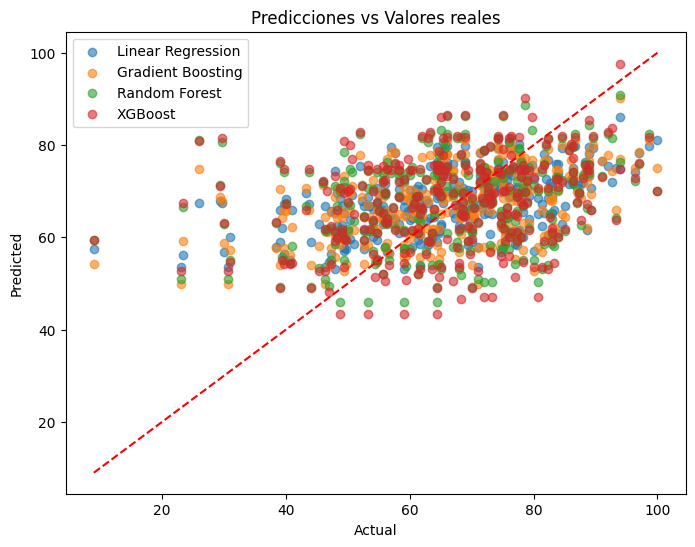

In [52]:
# --- VISUALIZACIÓN COMPARATIVA DE PREDICCIONES VS. VALORES REALES ---

# Importa el módulo pyplot de la librería Matplotlib con el alias 'plt'.
import matplotlib.pyplot as plt

# Establece el tamaño de la figura (el lienzo del gráfico) en 8 pulgadas de ancho por 6 de alto.
plt.figure(figsize=(8, 6))

# Crea un gráfico de dispersión (scatter plot) para cada modelo.
# En cada uno, el eje X son los valores reales ('y_test') y el eje Y son las predicciones del modelo.
# - 'label': Asigna un nombre a cada conjunto de puntos para la leyenda.
# - 'alpha=0.6': Establece la transparencia de los puntos para ver mejor las superposiciones.
plt.scatter(y_test, lm_predictions, label='Linear Regression', alpha=0.6)
plt.scatter(y_test, gbm_predictions, label='Gradient Boosting', alpha=0.6)
plt.scatter(y_test, rf_predictions, label='Random Forest', alpha=0.6)
plt.scatter(y_test, xgb_predictions, label='XGBoost', alpha=0.6)

# Dibuja una línea diagonal roja y discontinua que representa la predicción perfecta (y_real = y_predicho).
# Va desde el punto (min, min) hasta el (max, max) de los valores reales.
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# Etiqueta el eje horizontal (eje X) como 'Actual'.
plt.xlabel('Actual')
# Etiqueta el eje vertical (eje Y) como 'Predicted'.
plt.ylabel('Predicted')

# Muestra la leyenda del gráfico, que identifica los puntos de cada modelo.
plt.legend()
# Añade un título descriptivo al gráfico.
plt.title('Predicciones vs Valores reales')

# Renderiza y muestra el gráfico final en la pantalla.
plt.show()

### **Interpretación de la Gráfica: Ejes y Elementos Clave**

* **Eje X (Actual)**: Muestra los valores reales de la calificación promedio (`y_test`).
* **Eje Y (Predicted)**: Muestra los valores que cada modelo predijo para esos estudiantes.

***

### **¿Qué estamos viendo?**

1.  **Puntos de Dispersión**: Cada punto en el gráfico es un estudiante, ubicado según su calificación real (eje X) y la calificación predicha por un modelo (eje Y).
    * 🔵 **Azul**: Predicciones de la Regresión Lineal.
    * 🟠 **Naranja**: Predicciones de Gradient Boosting.
    * 🟢 **Verde**: Predicciones de Random Forest.
    * 🟣 **Púrpura**: Predicciones de XGBoost.
2.  **Línea Roja Discontinua**: Esta es la línea de la "predicción perfecta" ($y=x$). Si un modelo fuera 100% preciso, todos sus puntos caerían exactamente sobre esta línea.

***

### **Lectura de los Resultados**

1.  **Precisión General**: La distancia vertical de un punto a la línea roja representa su **error de predicción**. La dispersión general de los puntos alrededor de la línea nos indica que todos los modelos tienen un margen de error considerable.
2.  **Comparación entre Modelos**:
    * Los puntos de la **Regresión Lineal** y **XGBoost** tienden a agruparse un poco más cerca de la línea roja, lo que visualmente confirma su mejor rendimiento.
    * **Random Forest** muestra la mayor dispersión, con puntos muy alejados de la línea, reflejando su bajo R² y su incapacidad para capturar los patrones de los datos.
3.  **Tendencias y Errores Sistemáticos**:
    * Para estudiantes con calificaciones reales **bajas** (ej. `< 40`), todos los modelos tienden a **sobrestimar** (predecir una nota más alta de la que obtuvieron).
    * Para estudiantes con calificaciones reales **altas** (ej. `> 80`), los modelos tienden a **subestimar** (predecir una nota más baja).




### **10. Conclusión y Lecciones Clave** 🚀

A lo largo de este notebook, hemos cubierto pasos fundamentales en el preprocesamiento y modelado para un problema de regresión.

---
### **Recapitulación del Aprendizaje**

1.  **Codificación de Características**: Aprendimos la diferencia crucial entre variables **nominales** (sin orden) y **ordinales** (con jerarquía). Aplicamos `OneHotEncoder` y `OrdinalEncoder` de Scikit-learn para transformar estas variables categóricas en un formato numérico que los modelos pueden entender.

2.  **Ventajas de los Pipelines**: Confirmamos por qué Scikit-learn es la herramienta preferida sobre Pandas para el preprocesamiento en un flujo de machine learning. La capacidad de integrar la codificación en un **`Pipeline`** crea un flujo de trabajo cohesivo, reproducible y menos propenso a errores como la fuga de datos.

---
### **Sobre el Rendimiento de los Modelos**

El análisis comparativo nos dejó una conclusión importante: **ninguno de los modelos logró un rendimiento sobresaliente**.

* La dispersión observada en los gráficos sugiere que la relación entre las características y la calificación promedio es más compleja de lo que los modelos pudieron capturar.
* Esto nos indica que los siguientes pasos para mejorar el rendimiento serían:
    1.  **Ingeniería de Características (Feature Engineering)**: Explorar la creación de nuevas variables predictoras más informativas.
    2.  **Optimización de Hiperparámetros**: Ajustar los parámetros de los modelos más complejos (como `GradientBoosting` y `XGBoost`) para encontrar una configuración óptima.
    3.  **Análisis de Errores**: Investigar si valores atípicos (outliers) o ruido en los datos están afectando negativamente las predicciones.

---
### **Lección Clave: El Desafío de una Variable Objetivo Sintética**

Una de las lecciones más importantes de este ejercicio es que **la forma en que se crea la variable objetivo puede limitar el rendimiento del modelo**. Al promediar las tres calificaciones para crear `mean score`, introdujimos ciertas complejidades:

1.  **Pérdida de Información**: Al promediar, se pierde la variabilidad individual de cada materia. El modelo ya no puede aprender patrones específicos que podrían afectar solo a las matemáticas o a la lectura, por ejemplo.
2.  **Relaciones Indirectas**: Las variables predictoras (como el nivel educativo de los padres) pueden tener una relación más fuerte con una de las calificaciones originales que con el promedio. Al agregar los datos, estas relaciones directas se "diluyen", dificultando el aprendizaje del modelo.
3.  **Introducción de Sesgo**: El simple acto de promediar asume que las tres materias tienen la misma importancia. Si este no es el caso, estamos introduciendo un sesgo en nuestra variable objetivo que no refleja la realidad.

### **11. Próximos Pasos y Actividades Recomendadas** 🚀

Basado en nuestro análisis, el rendimiento de los modelos puede mejorarse significativamente. A continuación, se proponen varias estrategias para refinar nuestro enfoque y obtener predicciones más precisas.

---
#### **Mejoras en los Datos y Características** 📊

1.  **Replantear la Variable Objetivo**: En lugar de usar el promedio `mean score`, selecciona una de las calificaciones originales (ej. **`math score`**) como tu objetivo. Esto evitará la pérdida de información y permitirá al modelo aprender relaciones más directas.

2.  **Ingeniería de Características (Feature Engineering)**: Crea nuevas características a partir de las existentes. Por ejemplo, podrías generar variables de interacción (ej. `gender` y `parental level of education`) para capturar patrones más complejos.

3.  **Análisis de Correlación Detallado**: Evalúa la correlación entre cada variable predictora y tu nueva variable objetivo. Considera eliminar o transformar aquellas características con correlaciones muy bajas, ya que podrían no aportar información útil.

4.  **Transformar la Variable Objetivo**: Si la distribución de tu nueva variable objetivo es asimétrica (con sesgo), aplica transformaciones matemáticas como el **logaritmo (`np.log1p`)** para normalizarla. Esto puede ayudar a que los modelos de regresión funcionen mejor.

---
#### **Optimización y Exploración de Modelos** 🛠️

5.  **Ajuste de Hiperparámetros**: Para modelos complejos como `Gradient Boosting` y `Random Forest`, utiliza herramientas como **`GridSearchCV`** o **`RandomizedSearchCV`** para encontrar la combinación óptima de hiperparámetros.

6.  **Probar Otros Modelos**: Explora algoritmos más avanzados que son potentes para manejar relaciones no lineales, como:
    * **XGBoost** y **LightGBM**.
    * **Regresión con Vectores de Soporte (SVR)**.

7.  **Modelado por Segmentos**: Si observas que el modelo se comporta de manera diferente para distintos grupos de estudiantes (ej. de alto vs. bajo rendimiento), considera entrenar **modelos separados para cada segmento**.

---
#### **Validación Robusta y Diagnóstico** 🩺

8.  **Implementar Validación Cruzada**: En lugar de una única división de datos, usa **validación cruzada** (`cross_val_score`) para obtener una estimación más robusta y fiable del rendimiento de cada modelo.

9.  **Comparar con un Modelo Base**: Entrena un **`DummyRegressor`** que simplemente prediga el promedio. Si tus modelos no superan significativamente a este modelo base, es una señal de que tus características no son lo suficientemente predictivas.

10. **Validar el Impacto del Preprocesamiento**: Para diagnosticar problemas, entrena un modelo simple (como Regresión Lineal) sin el `ColumnTransformer` para ver si el preprocesamiento está afectando negativamente los resultados.

11. **Evaluar Métricas Alternativas**: No te fíes únicamente del R². Utiliza métricas como el **MAE (Error Absoluto Medio)** para entender el error promedio en las unidades originales de la calificación.



